In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df = pd.read_csv("HydroData_CleanedAndMerged.csv")
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.rename(columns={'generation hydro pumped storage consumption': 'consumption', 'generation hydro run-of-river and poundage': 'poundage', 
                   'generation hydro water reservoir': 'reservoir'}, inplace=True)

from datetime import datetime
df['time'] = [datetime.strptime(dt[:-6], '%Y-%m-%d %H:%M:%S') for dt in df['time']]
print(type(df['time'][0]))

df.head()
# df.tail()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,time,consumption,poundage,reservoir,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00,863.0,1051.0,1899.0,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00,920.0,1009.0,1658.0,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00,1164.0,973.0,1371.0,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00,1503.0,949.0,779.0,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00,1826.0,953.0,720.0,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0


In [5]:
grouped_data = df.groupby(pd.Grouper(key='time', freq='D'))#.sum()
result = grouped_data[['consumption', 'poundage', 'reservoir', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']].sum()
result['temp'] = grouped_data['temp'].median()
result['pressure'] = grouped_data['pressure'].mean()
result['humidity'] = grouped_data['humidity'].mean()
result['wind_speed'] = grouped_data['wind_speed'].mean()
result['wind_deg'] = grouped_data['wind_deg'].mean()

result['generation'] = result['poundage'] + result['reservoir']

result.reset_index(inplace=True)
result.head()

,time,consumption,poundage,reservoir,rain_1h,rain_3h,snow_3h,clouds_all,temp,pressure,humidity,wind_speed,wind_deg,generation
0,2015-01-01,25690.0,25149.0,52005.0,0.00,0.0,0.0,18.4,275.423900,1021.991667,75.391667,1.950000,181.600000,77154.0
1,2015-01-02,37048.0,31045.0,89159.0,0.00,0.0,0.0,143.4,276.434500,1024.441667,77.833333,1.575000,214.408333,120204.0
2,2015-01-03,32123.0,32994.0,95266.0,0.00,0.0,0.0,54.8,276.941384,1020.741667,78.591667,1.575000,191.033333,128260.0
3,2015-01-04,14160.0,35886.0,77792.0,1.02,0.0,0.0,274.4,278.064019,1015.858333,76.766667,1.258333,156.408333,113678.0
4,2015-01-05,19747.0,19814.0,43206.0,0.30,0.0,0.0,427.6,277.911800,1014.508333,81.158333,1.150000,174.300000,63020.0


In [11]:
# Separate Target Variable and Predictor Variables
TargetVariable=['generation']
Predictors=['rain_3h', 'snow_3h', 'clouds_all', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg']

X=result[Predictors].values
y=result[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(292, 8)
(292, 1)
(1169, 8)
(1169, 1)


In [86]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=8, input_dim=8, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=16, kernel_initializer='normal', activation='tanh'))

# model.add(Dense(units=32, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=32, kernel_initializer='normal', activation='tanh'))

# model.add(Dense(units=32, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=16, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

model.summary()

c:\Users\raosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,305 (5.10 KB)

 Trainable params: 1,305 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Fitting the ANN to the Training set
model_hist = model.fit(X_train, y_train ,batch_size = 8, epochs = 100, verbose=1, validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/100


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - MeanSquaredLogarithmicError: 0.2098 - loss: 0.9501 - val_MeanSquaredLogarithmicError: 0.2087 - val_loss: 1.0035
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredLogarithmicError: 0.2123 - loss: 0.9916 - val_MeanSquaredLogarithmicError: 0.2088 - val_loss: 1.0027
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredLogarithmicError: 0.2001 - loss: 0.9958 - val_MeanSquaredLogarithmicError: 0.1977 - val_loss: 0.9823
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredLogarithmicError: 0.1864 - loss: 0.9963 - val_MeanSquaredLogarithmicError: 0.1740 - val_loss: 0.9489
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredLogarithmicError: 0.1900 - loss: 0.9744 - val_MeanSquaredLogarithmicError: 0.1653 - val_loss: 0.9504
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredLogarithmicError: 0.1730 - loss: 0.9430 - val_MeanSquaredLogarithmicError: 0.1659 - val_loss: 0.9504
Epoch 7/100
37/37 ━━━━

In [99]:
y_pred = model.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
[[-0.37 -1.48]
 [ 0.42 -1.16]
 [ 0.88  2.48]
 ...
 [ 0.37 -0.07]
 [-0.17 -1.23]
 [-0.1   0.21]]


In [104]:
# Computing the absolute percent error
APE=100*(abs((y_test + 10) - (y_pred + 10))/(y_test + 10))
# TestingData['APE']=APE
 
print('The Accuracy of ANN model is:', 100-np.mean(APE))

The Accuracy of ANN model is: 92.39554814611995


In [89]:
import sklearn.metrics
ann = model
evs_no=sklearn.metrics.explained_variance_score(y_test,ann.predict(X_test))
me_no=sklearn.metrics.max_error(y_test,ann.predict(X_test))
mae_no=sklearn.metrics.mean_absolute_error(y_test,ann.predict(X_test))
mse_no=sklearn.metrics.mean_squared_error(y_test,ann.predict(X_test))
# msle_no=sklearn.metrics.mean_squared_log_error(y_test,ann.predict(X_test))
Mae_no=sklearn.metrics.median_absolute_error(y_test,ann.predict(X_test))
r2_no=sklearn.metrics.r2_score(y_test,ann.predict(X_test))
# mpd_no=sklearn.metrics.mean_poisson_deviance(y_test,ann.predict(X_test))
# mgd_no=sklearn.metrics.mean_gamma_deviance(y_test,ann.predict(X_test))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test,ann.predict(X_test))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


In [90]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
# print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.05141886822875408
Max Error               : 3.2369190398688863
Mean Absolute Error     : 0.7722446377733467
Mean Square Error       : 0.9551540955350629
Median Absolute Error   : 0.6480347304481744
R2 Score                : 0.04824253523845823
Mean Tweedie Deviance   : 0.9551540955350629


dict_keys(['MeanSquaredLogarithmicError', 'loss', 'val_MeanSquaredLogarithmicError', 'val_loss'])


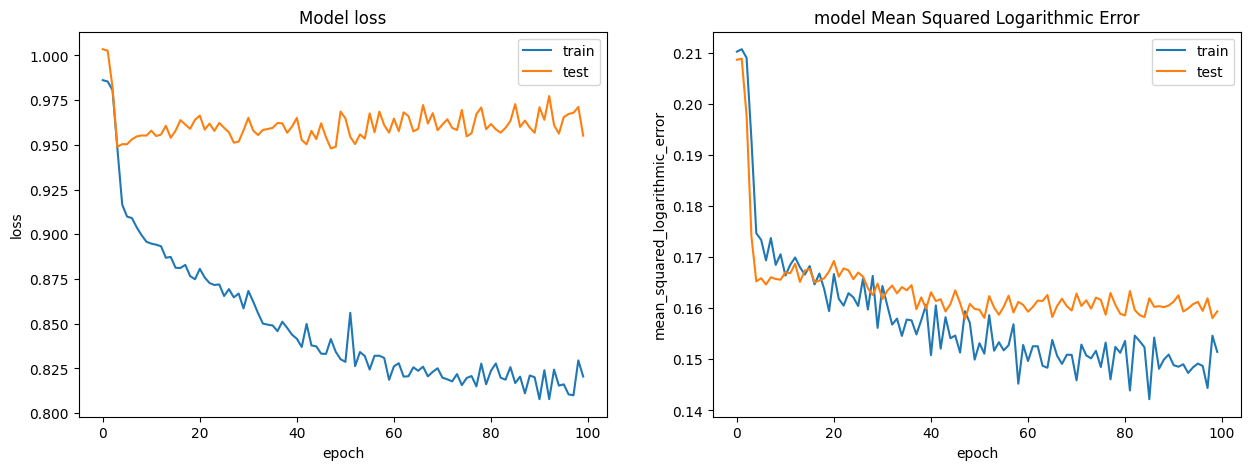

In [92]:
# list all data in history
print(model_hist.history.keys())

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
# plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
# plt.show()

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(model_hist.history['MeanSquaredLogarithmicError'])
plt.plot(model_hist.history['val_MeanSquaredLogarithmicError'])
# plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [93]:
import keras
model.save("ann_generation.keras")
loaded_model = keras.saving.load_model("ann_generation.keras")

In [94]:
y_pred = loaded_model.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[-0.37 -1.48]
 [ 0.42 -1.16]
 [ 0.88  2.48]
 ...
 [ 0.37 -0.07]
 [-0.17 -1.23]
 [-0.1   0.21]]


In [96]:
import sklearn.metrics
ann = loaded_model
evs_no=sklearn.metrics.explained_variance_score(y_test,ann.predict(X_test))
me_no=sklearn.metrics.max_error(y_test,ann.predict(X_test))
mae_no=sklearn.metrics.mean_absolute_error(y_test,ann.predict(X_test))
mse_no=sklearn.metrics.mean_squared_error(y_test,ann.predict(X_test))
# msle_no=sklearn.metrics.mean_squared_log_error(y_test,ann.predict(X_test))
Mae_no=sklearn.metrics.median_absolute_error(y_test,ann.predict(X_test))
r2_no=sklearn.metrics.r2_score(y_test,ann.predict(X_test))
# mpd_no=sklearn.metrics.mean_poisson_deviance(y_test,ann.predict(X_test))
# mgd_no=sklearn.metrics.mean_gamma_deviance(y_test,ann.predict(X_test))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test,ann.predict(X_test))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


In [97]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
# print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.05141886822875408
Max Error               : 3.2369190398688863
Mean Absolute Error     : 0.7722446377733467
Mean Square Error       : 0.9551540955350629
Median Absolute Error   : 0.6480347304481744
R2 Score                : 0.04824253523845823
Mean Tweedie Deviance   : 0.9551540955350629
